# Анализ влияния различных параметров на распределение давления в трубе (простой фонтанирующей скважине)

версия 0.2 от 12.5.20


In [18]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
import pandas as pd
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [19]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание функции  `MF_p_pipeline_atma`
Расчет распределения давления и температуры в трубопроводе может быть выполнен с помощью функции `MF_p_pipeline_atma`
В данной функции градиент давления рассчитывается с помощью многофазный корреляций, которые позволяют учесть сложные процессы, происходящие при совместном движении нефти, газа и воды.

Расчет может быть проведен для нескольких корреляций, определяемых параметром `Hydr_corr_ `. Допустимые варианты ниже. 
````python
    BeggsBrill = 0
    Ansari = 1
    Unified = 2
    Gray = 3
    HagedornBrown = 4
    SakharovMokhov = 5
    gas = 10
    Water = 11
````
Функция возвращает несколько tuples (неизменяемых списков python), при этом количество данных в выводе может варьироваться по усмотрению пользователя

Зададим исходные данные по флюиду с помощью словаря

Обычная стандартная PVT строка

In [20]:
pvt_str_data_oil_annulus = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":100,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0,
"p_ksep_atma":-1,
"t_ksep_C":-1,
"gas_only":False
               }

Затем зададим непосредственно параметры, которые нужны для расчета данной функции

При этом здесь же создадим PVT строку, вызвав функцию `pvt_str_data`

Отметим, что ось направлена вниз, расчет по направлению оси (снизу-вверх), поток против направления расчета (вверх) - итого 
`"calc_flow_direction":10`, т.е. добывающая вертикальная скважина

In [21]:
pipeline_data_oil_annulus = {"p_calc_from_atma": 50,
"t_calc_from_C": 50,
"t_val":20,
"h_list_m" : 2000,
"diam_list_mm" : 50,
"qliq_sm3day" : 0,
"fw_perc":0,
"q_gas_sm3day":0,
"str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus),
"calc_flow_direction":0,
"hydr_corr":0,
"temp_method":1,
"c_calibr":1,
"roughness_m":0.0001,
"out_curves":2,
"out_curves_num_points":10}

Также для удобства напишем функцию, для обработки исходной выдачи функции

In [22]:
def covert_vba_result(vba_result, option=0):
    if option == 0: #возвращаем только рассчитанные давление и температуру
        result = vba_result[0][0], vba_result[0][1]
    elif option == 1:
        result = pd.DataFrame(vba_result) #возвращает необработанный DataFrame
    elif option == 2: #возвращает обработанный DataFrame с распределением свойств
        result = pd.DataFrame(vba_result)
        result.columns = result[result.index==2].iloc[0]
        result = result[result.index>2]
        result = result.set_index('hvert,m')
    return result    

In [23]:
vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data_oil_annulus)
r = covert_vba_result(vba_result,2)

Получим список всех параметров, доступных для построения

In [24]:
for i in r.columns:
    print(i, end = ', ')

num, h,m, p,atma, t,C, Hl, fpat, t_amb, C, diam, m, c_Roughness, c_Theta, c_Tinit, c_P, c_T, c_Tamb, c_udl_m, c_dpdl_g, c_dpdl_f, c_dpdl_a, c_vsl, c_vsg, c_Hl, c_gasfrac, c_muo, c_muw, c_mug, c_mumix, c_rhoo, c_rhow, c_rhol, c_rhog, c_rhomix, c_qo, c_qw, c_qg, c_mo, c_mw, c_mg, c_vl, c_vg, c_Rs, 

Теперь напишем функцию, которая позволит нам изменять входные данные и провести анализ чувствительности.

При этом передача входных данных (словарей - dicts) будем проводить через копии объектов, чтобы не изменять данные вне функции

In [25]:
def sense_profile(pipeline_data, pvt_str_data, parameter_sense, range_sense, pvt_edit=False, parameter_to_plot='p,atma'):
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            pipeline_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            pipeline_data[parameter_sense] = i
        vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
        r = covert_vba_result(vba_result,2)
        plt.plot(r[parameter_to_plot], r.index * (-1), label = f"{parameter_sense} = {i}")
    plt.legend(loc='upper right')
    plt.xlabel(parameter_to_plot)
    plt.ylabel('Глубина, м')
    fig.suptitle(f"Распределение параметра {parameter_to_plot} в фонтанирующей скважине при различных {parameter_sense}", fontsize = 18)
    plt.show()

Проведем анализ чувствительности при изменения газосодержания нефти при давлении насыщения. Как видно из рисунка, при большой газонасыщенности требуется меньший перепад давления, чтобы поднять флюид на поверхность. Форма кривой также меняется из-за газа

In [26]:
def calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, p_calc_annulus_atma):
    pvt_str_data_gas_annulus = pvt_str_data_oil_annulus.copy()
    pvt_str_data_gas_annulus['gas_only'] = 1
    pvt_str_annulus = UniflocVBA.PVT_encode_string(**pvt_str_data_gas_annulus)

    pipeline_data_gas_annulus = pipeline_data_oil_annulus.copy()
    pipeline_data_gas_annulus["str_PVT"] = pvt_str_annulus
    pipeline_data_gas_annulus["t_val"] = pipeline_data_oil_annulus["t_calc_from_C"]
    pipeline_data_gas_annulus["t_calc_from_C"] = pipeline_data_oil_annulus["t_val"]

    pipeline_data_gas_annulus['p_calc_from_atma'] = p_calc_annulus_atma
    pipeline_data_gas_annulus['calc_flow_direction'] = 10
    
    vba_result_oil_annulus = covert_vba_result(UniflocVBA.MF_p_pipeline_atma(**pipeline_data_oil_annulus),2)
    vba_result_gas_annulus = covert_vba_result(UniflocVBA.MF_p_pipeline_atma(**pipeline_data_gas_annulus),2)
    
    this_hdyn_m = UniflocVBA.crv_intersection(vba_result_oil_annulus.index.values * (-1),   vba_result_oil_annulus['p,atma'].values, 
                           vba_result_gas_annulus.index.values * (-1),   vba_result_gas_annulus['p,atma'].values)
    
    print(pipeline_data_oil_annulus)
    if vba_result_oil_annulus['p,atma'][0] > 0:
        this_hdyn_m = 0
    return vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m

In [27]:
vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, 20)
this_hdyn_m

{'p_calc_from_atma': 50, 't_calc_from_C': 50, 't_val': 20, 'h_list_m': 2000, 'diam_list_mm': 50, 'qliq_sm3day': 0, 'fw_perc': 0, 'q_gas_sm3day': 0, 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:100,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;', 'calc_flow_direction': 0, 'hydr_corr': 0, 'temp_method': 1, 'c_calibr': 1, 'roughness_m': 0.0001, 'out_curves': 2, 'out_curves_num_points': 10}


(-1654.1104198925489,)

{'p_calc_from_atma': 50, 't_calc_from_C': 50, 't_val': 20, 'h_list_m': 2000, 'diam_list_mm': 50, 'qliq_sm3day': 0, 'fw_perc': 0, 'q_gas_sm3day': 0, 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:100,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;', 'calc_flow_direction': 0, 'hydr_corr': 0, 'temp_method': 1, 'c_calibr': 1, 'roughness_m': 0.0001, 'out_curves': 2, 'out_curves_num_points': 10}
Для q_gas_sm3day = 0 динамический уровень = (-1654.1104198925489,)
{'p_calc_from_atma': 50, 't_calc_from_C': 50, 't_val': 20, 'h_list_m': 2000, 'diam_list_mm': 50, 'qliq_sm3day': 0, 'fw_perc': 0, 'q_gas_sm3day': 500, 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:100,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;', 'calc_flow_direction': 0, 'hydr_c

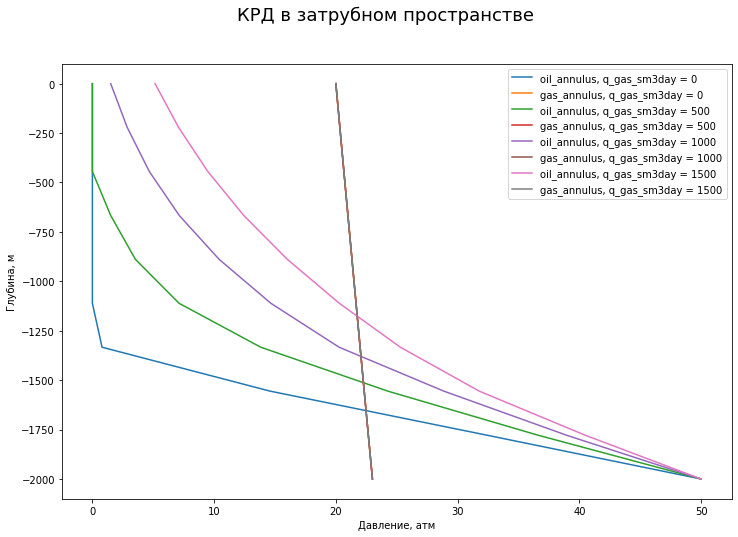

In [28]:
fig = plt.figure()
for i in range(0, 2000, 500):
    pipeline_data_oil_annulus['q_gas_sm3day'] = i
    vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus, pipeline_data_oil_annulus, 20)
    plt.plot(vba_result_oil_annulus['p,atma'], vba_result_oil_annulus.index * (-1), label = f"oil_annulus, q_gas_sm3day = {i}")
    plt.plot(vba_result_gas_annulus['p,atma'], vba_result_gas_annulus.index * (-1), label = f"gas_annulus, q_gas_sm3day = {i}")
    print(f"Для q_gas_sm3day = {i} динамический уровень = {this_hdyn_m}")
plt.legend(loc='upper right')
plt.xlabel('Давление, атм')
plt.ylabel('Глубина, м')
fig.suptitle(f"КРД в затрубном пространстве", fontsize = 18)
plt.show()

In [29]:
def calc_annulus_with_sep(pvt_str_data_oil_annulus, pipeline_data_oil_annulus,
                          p_calc_annulus_atma, ksep_d, qliq_sm3day, fw_perc):
    
    qliq_m3day = qliq_sm3day
    fw_perc = fw_perc
    p_intake_atma = pipeline_data_oil_annulus['p_calc_from_atma']
    t_intake_c = pipeline_data_oil_annulus['t_calc_from_C']
    
    pvt_str_data_oil_annulus_with_sep = pvt_str_data_oil_annulus.copy()
    pvt_str_data_oil_annulus_with_sep['p_ksep_atma'] = p_intake_atma
    pvt_str_data_oil_annulus_with_sep['t_ksep_C'] = t_intake_c
    pvt_str_data_oil_annulus_with_sep['ksep_fr'] = ksep_d
    
    qmix_intake_before_sep_m3day = UniflocVBA.MF_q_mix_rc_m3day(qliq_m3day, fw_perc, p_intake_atma, t_intake_c,
                                                            UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus))

    qmix_intake_after_sep_m3day = UniflocVBA.MF_q_mix_rc_m3day(qliq_m3day, fw_perc,  p_intake_atma, t_intake_c, 
                                                            UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))

    gas_fraction_before_sep = UniflocVBA.MF_gas_fraction_d(p_intake_atma, t_intake_c, 
                                                       str_PVT = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus))

    gas_fraction_after_sep = UniflocVBA.MF_gas_fraction_d(p_intake_atma, t_intake_c, 
                                                      str_PVT = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))

    qgas_free_before = qmix_intake_before_sep_m3day * gas_fraction_before_sep
    qgas_free_after = qmix_intake_after_sep_m3day * gas_fraction_after_sep
    qgas_separated_m3day = qgas_free_before - qgas_free_after
    
    bg_m3m3 = UniflocVBA.PVT_bg_m3m3(p_intake_atma, t_intake_c, 
                                     str_PVT=UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus_with_sep))


    
    qgas_m3day = qgas_separated_m3day / bg_m3m3
        
    pipeline_data_oil_annulus['q_gas_sm3day'] = qgas_m3day
    vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus(pvt_str_data_oil_annulus,
                                                                               pipeline_data_oil_annulus,
                                                                               p_calc_annulus_atma)
    return vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m

In [30]:
def sense_annulus(pipeline_data, pvt_str_data, parameter_sense,
                  range_sense, pvt_edit=False, p_calc_annulus_atma=20):
    
    fig = plt.figure()
    
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            pipeline_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            pipeline_data[parameter_sense] = i
            
            
        pvt_str_data_oil_annulus = pvt_str_data.copy()
        pvt_str_data_oil_annulus['ksep_fr'] = 0
        pvt_str_data_oil_annulus['p_ksep_atma'] = -1
        pvt_str_data_oil_annulus['t_ksep_C'] = -1
        

        pipeline_data_oil_annulus = pipeline_data.copy()
        pipeline_data_oil_annulus['qliq_sm3day'] = 0
        pipeline_data_oil_annulus['fw_perc'] = 0
        pipeline_data_oil_annulus['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data_oil_annulus)
        
        vba_result_oil_annulus, vba_result_gas_annulus, this_hdyn_m = calc_annulus_with_sep(pvt_str_data_oil_annulus, 
                                                                                            pipeline_data_oil_annulus,
                                                                                            p_calc_annulus_atma, 
                                                                                            pvt_str_data['ksep_fr'], 
                                                                                            pipeline_data['qliq_sm3day'],
                                                                                            pipeline_data['fw_perc'])
        plt.plot(vba_result_oil_annulus['p,atma'], vba_result_oil_annulus.index * (-1),
                 label = f"oil_annulus, {parameter_sense} = {i}")
        plt.plot(vba_result_gas_annulus['p,atma'], vba_result_gas_annulus.index * (-1),
                 label = f"gas_annulus, {parameter_sense} = {i}")
        
        print(f"Для {parameter_sense} = {i} динамический уровень = {this_hdyn_m}")
    
    
    plt.legend(loc='upper right')
    plt.xlabel('Давление, атм')
    plt.ylabel('Глубина, м')
    fig.suptitle(f"КРД в затрубном пространстве", fontsize = 18)
    plt.show()

In [31]:
pvt_str_data = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":70,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0.5,
"p_ksep_atma":50,
"t_ksep_C":50,
"gas_only":False
               }

In [32]:
pipeline_data = {"p_calc_from_atma": 50,
"t_calc_from_C": 50,
"t_val":20,
"h_list_m" : 2500,
"diam_list_mm" : 50,
"qliq_sm3day" : 20,
"fw_perc":0,
"q_gas_sm3day":0,
"str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
"calc_flow_direction":0,
"hydr_corr":0,
"temp_method":1,
"c_calibr":1,
"roughness_m":0.0001,
"out_curves":2,
"out_curves_num_points":10}

{'p_calc_from_atma': 50, 't_calc_from_C': 50, 't_val': 20, 'h_list_m': 2500, 'diam_list_mm': 50, 'qliq_sm3day': 0, 'fw_perc': 0, 'q_gas_sm3day': 289.87491090610223, 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:70,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;', 'calc_flow_direction': 0, 'hydr_corr': 0, 'temp_method': 1, 'c_calibr': 1, 'roughness_m': 0.0001, 'out_curves': 2, 'out_curves_num_points': 10}
Для ksep_fr = 0.3 динамический уровень = (-2080.539814466741,)
{'p_calc_from_atma': 50, 't_calc_from_C': 50, 't_val': 20, 'h_list_m': 2500, 'diam_list_mm': 50, 'qliq_sm3day': 0, 'fw_perc': 0, 'q_gas_sm3day': 484.6903440646697, 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:70,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;', 'calc_fl

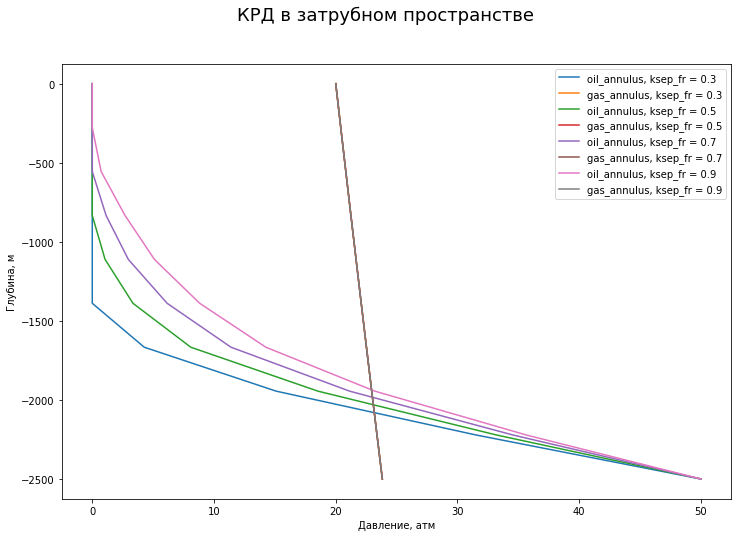

In [33]:
sense_annulus(pipeline_data.copy(), pvt_str_data.copy(), 'ksep_fr', [0.3,0.5,0.7,0.9], pvt_edit=True)